In [2]:
from IPython.display import display
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.special import softmax
import pickle
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
import matplotlib
matplotlib.rcParams.update({"font.size": 15, 
                            "font.family": "STIXGeneral",
                            "mathtext.fontset": "cm"})
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
model_types = ["teacher", "BERT", "LSTM"]
seeds = {"teacher": [""], 
         "LSTM": ["", "-s47", "-s48"],
         "BERT": ["", "-s47", "-s48"]
        }
glue_tasks = ["CoLA", "SST-2", "Sara"]
classes = {"CoLA": np.arange(2), "SST-2": np.arange(2), "Sara": np.arange(57)}
class_names = {
    "CoLA": {0: "unacc.", 1: "acc."},
    "SST-2": {0: "neg.", 1: "pos."},
    "Sara": {0: "affirm", 1: "ask_builder", 2: "ask_faq_channels", 3: "ask_faq_community_size", 4: "ask_faq_differencecorenlu", 5: "ask_faq_languages", 6: "ask_faq_opensource", 7: "ask_faq_platform", 8: "ask_faq_python_version", 9: "ask_faq_slots", 10: "ask_faq_tutorials", 11: "ask_faq_voice", 12: "ask_faq_what_is_forum", 13: "ask_how_contribute", 14: "ask_howbuilt", 15: "ask_howdoing", 16: "ask_howold", 17: "ask_isbot", 18: "ask_languagesbot", 19: "ask_question_in_forum", 20: "ask_restaurant", 21: "ask_time", 22: "ask_weather", 23: "ask_whatismyname", 24: "ask_whatisrasa", 25: "ask_whatspossible", 26: "ask_when_next_event", 27: "ask_wherefrom", 28: "ask_which_events", 29: "ask_whoami", 30: "ask_whoisit", 31: "ask_why_contribute", 32: "bye", 33: "canthelp", 34: "contact_sales", 35: "deny", 36: "enter_data", 37: "greet", 38: "handleinsult", 39: "how_to_get_started", 40: "human_handoff", 41: "install_rasa", 42: "next_step", 43: "nicetomeeyou", 44: "nlu_generation_tool_recommendation", 45: "nlu_info", 46: "out_of_scope", 47: "pipeline_recommendation", 48: "rasa_cost", 49: "react_negative", 50: "react_positive", 51: "signup_newsletter", 52: "source_code", 53: "switch", 54: "technical_question", 55: "telljoke", 56: "thank"}
}
model_colours = { # http://mkweb.bcgsc.ca/colorblind/
    "teacher": (150, 75, 0), # brown (0, 0, 0), # black
    "LSTM": (86, 180, 233), # sky blue
    "BERT": (230, 159, 0), # orange
}
model_colours = {name: np.array(c)/255 for name, c in model_colours.items()}

In [4]:
def colourcode_confidences(data):
    minimum = data[["c_t", "c_B", "c_L"]].min()
    maximum = data[["c_t", "c_B", "c_L"]].min()
    minimum = min(minimum.values)
    maximum = min(maximum.values)
    return data.style.background_gradient(cmap="RdYlGn", low=minimum, high=maximum, 
                                          axis=0, subset=["c_t", "c_B", "c_L"])

def decode_labels(data, task):
    if task == "Sara":
        data["label"] = data["label"].map(lambda l: class_names["Sara"][l])
        for model_type in model_types:
            data["pred_" + model_type] = data["pred_" + model_type].map(lambda l: class_names["Sara"][l])
    return data

# Processing predictions for a given task

In [45]:
Hs_all = {}
N = 50
for task in glue_tasks:
    print("\n" + task)
    Hs_all[task] = {}
    data_all = {}
    avg_confidences = {}
    n_mistakes = {}
    for model_type in model_types:
        Hs_all[task][model_type] = {}
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        data_all[model_type] = data
        
        avg_confidences[model_type] = data["certainty_of_pred"].mean() 
        
        # Average entropy
        Hs = []
        for i, sample in data.iterrows():
            logits = np.array([float(l) for l in sample["logits"].split(",")])
            Hs.append(entropy(softmax(logits)))
        H_mean = np.mean(Hs)
        H_std = np.std(Hs)
        Hs_all[task][model_type]["mean"] = H_mean
        Hs_all[task][model_type]["std"] = H_std
        
        # Mistakes, hits
        mistakes = data[data["pred"] != data["label"]].sort_values(by="certainty_of_pred", ascending=False)
        hits = data[data["pred"] == data["label"]].sort_values(by="certainty_of_pred", ascending=False)
        n_mistakes[model_type] = len(mistakes)

        examples = {}
        examples["confident mistakes"] = mistakes[:N]
        examples["unconfident mistakes"] = mistakes[-N:][::-1]
        examples["confident hits"] = hits[:N]
        examples["unconfident hits"] = hits[-N:][::-1]
        with open("mistakes-hits/{}_{}.tsv".format(task, model_type), "w") as f:
            f.write("confidence\ttrue\tpredicted\tsentence")
            for kind in ["confident mistakes", "unconfident mistakes", "confident hits", "unconfident hits"]:
                f.write("\n{}\t \t \t \n".format(kind.upper()))
                for i, ex in examples[kind].iterrows():
                    f.write("{:.3f}\t{}\t{}\t{}\n".format(ex["certainty_of_pred"], 
                                                       class_names[task][ex["label"]],
                                                       class_names[task][ex["pred"]],
                                                       ex["sentence"]))
    print(" | ".join(model_types))
    print(" | ".join(["{:.2f} ".format(Hs_all[task][m]["mean"]) for m in model_types]) + " (avg entropy)")
    print(" | ".join(["{:.2f} ".format(avg_confidences[m]) for m in model_types]) + " (avg confidence)")
    print(" | ".join(["{:.3f}".format(n_mistakes[m]/len(data_all["teacher"])) for m in model_types]) + " (% mistakes)")
    
    for model_type in model_types:
        for seed in seeds[model_type]:
            model_type_seed = model_type + seed
            data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type_seed), delimiter="\t")
            data_all[model_type_seed] = data
    
    full_pred_df = data_all["teacher"][["sentence", "label"]]
    for model_type in model_types:
        for seed in seeds[model_type]:
            model_type_seed = model_type + seed
            full_pred_df = full_pred_df.merge(
                data_all[model_type_seed]["pred"].rename("pred_{}".format(model_type_seed)), 
                left_index=True, right_index=True)
            full_pred_df = full_pred_df.merge(
                data_all[model_type_seed]["certainty_of_pred"].rename("confidence_{}".format(model_type_seed)).round(decimals=2), 
                left_index=True, right_index=True)
    full_pred_df.to_csv("predictions/full_predictions-{}.csv".format(task), index=False)
    
    unequal_prediction_indices = (data_all["teacher"]["pred"] != data_all["BERT"]["pred"]) | (data_all["teacher"]["pred"] != data_all["LSTM"]["pred"])
    unequal_prediction_samples = data_all["teacher"][unequal_prediction_indices][["sentence", "label"]]
    print("{} samples were predicted differently by the 3 model types.".format(len(unequal_prediction_samples)))
    for model_type in model_types:
        unequal_prediction_samples = unequal_prediction_samples.merge(
            data_all[model_type]["pred"].rename("pred_{}".format(model_type)), 
            left_index=True, right_index=True)
        unequal_prediction_samples = unequal_prediction_samples.merge(
            data_all[model_type]["certainty_of_pred"].rename("confidence_{}".format(model_type)).round(decimals=2), 
            left_index=True, right_index=True)
    unequal_prediction_samples.to_csv("predictions/unequal_prediction_samples-{}.csv".format(task), index=False)
    
with open("predictions/eval_prediction_entropies.pkl", 'wb') as handle:
    pickle.dump(Hs_all, handle, protocol=pickle.HIGHEST_PROTOCOL)


CoLA
teacher | BERT | LSTM
0.21  | 0.25  | 0.28  (avg entropy)
0.93  | 0.91  | 0.89  (avg confidence)
0.162 | 0.219 | 0.228 (% mistakes)
247 samples were predicted differently by the 3 model types.

SST-2
teacher | BERT | LSTM
0.10  | 0.15  | 0.13  (avg entropy)
0.97  | 0.95  | 0.95  (avg confidence)
0.085 | 0.107 | 0.088 (% mistakes)
87 samples were predicted differently by the 3 model types.

Sara
teacher | BERT | LSTM
0.29  | 0.37  | 0.51  (avg entropy)
0.94  | 0.92  | 0.89  (avg confidence)
0.125 | 0.129 | 0.135 (% mistakes)
84 samples were predicted differently by the 3 model types.


## Adding grammatical annotations (CoLA)

Some sentences needed to be corrected in the predictions because they contained mistakes (whereas the versions in the annotated data did not contain the mistakes):
- he could not] have been working. -> he could not] have been working.
- a proof that the claim had been. made was giver that john had lied. -> a proof that the claim had been made was given that john had lied.
- which boy's, mother, did you meet who you liked? -> which boy's mother did you meet who you liked?
- which boy's, mother, did you meet? -> which boy's mother did you meet?

In [14]:
# 15 major
# cols_major = ["Simple", "Predicate", "Adjunct", "Argument Type", "Arg Altern", "Imperative", "Binding", "Question", "Comp Clause", "Auxiliary", "to-VP", "N, Adj", "S-Syntax", "Determiner", "Violations"]
cols_major = ["Simple", "Predicate", "Adjunct", "Argument Type", "Arg Altern", "Binding", "Question", "Comp Clause", "Auxiliary", "to-VP", "N, Adj", "S-Syntax", "Determiner"]
# 63 minor
cols_minor = ["Simple", "Copula", "Pred/SC", "Result/Depictive", "Particle", "VP Adjunct", "NP Adjunct", "Temporal", "Locative", "Misc", "Oblique", "PP Arg-VP", "PPArg-NP/AP", "by-Phrase", "Expletive", "High Arity", "Drop Arg", "Add Arg", "Passive", "Imperative", "Binding:Refl", "Binding:Other", "Matrix Q", "Emb Q", "Complex QP", "RC", "Island", "CP Subj", "CP Arg VP", "CP Arg NP/AP", "Non-finite CP", "No C-izer", "Deep Embed", "Neg", "Modal", "Aux", "Psuedo-Aux", "Control", "Raising", "VP+Extract", "VP arg-NP/AP", "Non-finite VP Misc", "Deverbal", "Rel NP", "Trans NP", "Compx NP", "NNCompd", "Rel Adj", "Trans Adj", "Dislocation", "Info Struc", "Frag/Paren", "Coord", "Subordinate/Cond", "Ellipsis/Anaphor", "S-Adjunct", "Quantifier", "Partitive", "NPI/FCI", "Comparative", "Sem  Violation", "Infl/Agr Violation", "Extra/Mising Expr"]
data = pd.read_csv("predictions/full_predictions-CoLA.csv")
annot_major = pd.read_csv("../../data/glue_data/CoLA/CoLA_grammatical_annotations_major_features.tsv",
                               delimiter="\t", converters={"Sentence": lambda s: s.lower()})
annot_minor = pd.read_csv("../../data/glue_data/CoLA/CoLA_grammatical_annotations_minor_features.tsv",
                               delimiter="\t", converters={"Sentence": lambda s: s.lower()})

In [31]:
def get_sent_annots(sent, kind="major"):
    if kind == "major":
        annots = annot_major[annot_major["Sentence"] == sent]
        if len(annots) != 1:
            print(sent, len(annots))
            if len(annots) == 0: return []
        return [col for col in annot_major.columns[4:] if (annots[col] == 1).all()]
    if kind == "minor":
        annots = annot_minor[annot_minor["Sentence"] == sent]
        if len(annots) != 1:
            print(sent, len(annots))
            if len(annots) == 0: return []
        return [col for col in annot_minor.columns[4:] if (annots[col] == 1).all()]

In [32]:
annots_major_column = [get_sent_annots(r["sentence"]) for i, r in data.iterrows()]
annots_minor_column = [get_sent_annots(r["sentence"], kind="minor") for i, r in data.iterrows()]
data = data.assign(annot_major=annots_major_column)
data = data.assign(annot_minor=annots_minor_column)
data.to_csv("predictions/full_predictions-CoLA.csv", index=False)

i forgot how good beer tastes. 2
i know that meg's attracted to harry, but they don't know who. 2
i know that meg's attracted to harry, but they don't know who. 2
the ta's have been arguing about whether some student or other should pass, but i can't now remember which one. 2
the ta's have been arguing about whether some student or other should pass, but i can't now remember which one. 2
i forgot how good beer tastes. 2
i forgot how good beer tastes. 2
i know that meg's attracted to harry, but they don't know who. 2
i know that meg's attracted to harry, but they don't know who. 2
the ta's have been arguing about whether some student or other should pass, but i can't now remember which one. 2
the ta's have been arguing about whether some student or other should pass, but i can't now remember which one. 2
i forgot how good beer tastes. 2


In [33]:
for model_type in model_types:
    data = pd.read_csv("mistakes-hits/CoLA_{}.tsv".format(model_type), delimiter="\t")
    annots_major_column = [get_sent_annots(r["sentence"]) for i, r in data.iterrows()]
    annots_minor_column = [get_sent_annots(r["sentence"], kind="minor") for i, r in data.iterrows()]
    data = data.assign(annot_major=annots_major_column)
    data = data.assign(annot_minor=annots_minor_column)
    data.to_csv("mistakes-hits/CoLA_{}.tsv".format(model_type), index=False, sep="\t")

  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0


# Individual models

## Confident/unconfident hits/misses of each individual student

In [54]:
task = "SST-2"
model_type = "BERT"

data = pd.read_csv("mistakes-hits/{}_{}.tsv".format(task, model_type), delimiter="\t")
data = data[["confidence", "sentence", "true", "predicted"]]
display(data)

,confidence,sentence,true,predicted
0,CONFIDENT MISTAKES,,,
1,0.996,"it 's somewhat clumsy and too lethargically paced -- but its story about a mysterious creature with psychic abilities offers a solid build-up , a terrific climax , and some nice chills along the way .",neg.,pos.
2,0.995,"outer-space buffs might love this film , but others will find its pleasures intermittent .",neg.,pos.
3,0.995,"although huppert 's intensity and focus has a raw exhilaration about it , the piano teacher is anything but fun .",neg.,pos.
4,0.994,"you wo n't like roger , but you will quickly recognize him .",neg.,pos.
5,0.993,"irwin is a man with enough charisma and audacity to carry a dozen films , but this particular result is ultimately held back from being something greater .",neg.,pos.
6,0.992,as unseemly as its title suggests .,pos.,neg.
7,0.992,"it 's inoffensive , cheerful , built to inspire the young people , set to an unending soundtrack of beach party pop numbers and aside from its remarkable camerawork and awesome scenery , it 's about as exciting as a sunburn .",neg.,pos.
8,0.991,"you really have to wonder how on earth anyone , anywhere could have thought they 'd make audiences guffaw with a script as utterly diabolical as this .",neg.,pos.
9,0.990,this riveting world war ii moral suspense story deals with the shadow side of american culture : racial prejudice in its ugly and diverse forms .,neg.,pos.


# Comparing models

In [53]:
task = "Sara"

## Cases where one student is confident, the other one unconfident

In [54]:
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
data = decode_labels(data, task)
confidence_diff = data["confidence_BERT"] - data["confidence_LSTM"]
data = data.merge(confidence_diff.rename("diff"), left_index=True, right_index=True)
data = data.rename(columns={"confidence_{}".format(m): "c_{}".format(m[:1]) for m in model_types})
data = data.rename(columns={"pred_{}".format(m): "{}".format(m) for m in model_types})
data = data[["sentence", "label", "teacher", "c_t", "LSTM", "c_L", "BERT", "c_B", "diff"]]
N = 10
data = pd.concat([data.sort_values(by=["diff"], ascending=False)[:N], 
                  data.sort_values(by=["diff"], ascending=True)[:N]])
colourcode_confidences(data)

,sentence,label,teacher,c_t,LSTM,c_L,BERT,c_B,diff
568,my budget is oov,enter_data,enter_data,1,enter_data,0.31,enter_data,1,0.69
526,places,enter_data,out_of_scope,0.3,ask_restaurant,0.28,enter_data,0.86,0.58
912,get the latest news from rasa,signup_newsletter,signup_newsletter,0.22,signup_newsletter,0.23,signup_newsletter,0.78,0.55
190,you originated through what means?,ask_howbuilt,ask_howbuilt,0.89,ask_whatisrasa,0.12,out_of_scope,0.67,0.55
228,when do you celebrate your day of birth?,ask_howold,ask_howold,0.98,ask_howold,0.38,ask_howold,0.92,0.54
947,your specifications,technical_question,source_code,0.54,out_of_scope,0.37,out_of_scope,0.91,0.54
854,"i am hungry, what should i do?",out_of_scope,out_of_scope,0.99,out_of_scope,0.46,out_of_scope,0.99,0.53
198,i'd like to know how you were put together?,ask_howbuilt,ask_howbuilt,0.96,ask_howbuilt,0.42,ask_howbuilt,0.94,0.52
93,what facts diverge core from nlu?,ask_faq_differencecorenlu,ask_faq_differencecorenlu,0.99,ask_faq_differencecorenlu,0.44,ask_faq_differencecorenlu,0.96,0.52
293,what am i called?,ask_whatismyname,ask_whatismyname,0.96,ask_whatismyname,0.46,ask_whatismyname,0.97,0.51


## Cases where one student is right and the other is wrong
The teacher should be right in the first place, indicating that the students "stand a chance".

In [55]:
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
data = decode_labels(data, task)
data = data[data["label"] == data["pred_teacher"]]
data = data[(data["label"] == data["pred_LSTM"]) | (data["label"] == data["pred_BERT"])]
data = data[data["pred_BERT"] != data["pred_LSTM"]]
data = data.rename(columns={"confidence_{}".format(m): "c_{}".format(m[:1]) for m in model_types})
data = data.rename(columns={"pred_{}".format(m): "{}".format(m) for m in model_types})
data = data.sort_values(by=["label"])
data = data[["sentence", "label", "teacher", "c_t", "LSTM", "c_L", "BERT", "c_B"]]
N = 10
data = shuffle(data, random_state=42, n_samples=N)
data = data.sort_values(by=["LSTM"])
colourcode_confidences(data)

,sentence,label,teacher,c_t,LSTM,c_L,BERT,c_B
56,who went through the trouble of setting you up?,ask_builder,ask_builder,0.99,ask_builder,0.97,technical_question,0.16
51,by whom were you built?,ask_builder,ask_builder,0.67,ask_howbuilt,0.62,ask_builder,0.59
239,are you bilingual?,ask_languagesbot,ask_languagesbot,0.98,ask_languagesbot,0.59,out_of_scope,0.34
694,tell me something about core,how_to_get_started,how_to_get_started,0.96,ask_whatisrasa,0.84,how_to_get_started,0.94
429,i decline,deny,deny,0.98,deny,0.34,out_of_scope,0.27
858,i ned a gp in 94301,out_of_scope,out_of_scope,0.99,enter_data,0.58,out_of_scope,0.99
810,"alexa, order 5 tons of natrium chloride",out_of_scope,out_of_scope,1,out_of_scope,0.4,ask_faq_voice,0.73
848,get me a club mate,out_of_scope,out_of_scope,0.78,out_of_scope,0.9,human_handoff,0.31
881,how much is it,rasa_cost,rasa_cost,0.77,out_of_scope,0.54,rasa_cost,0.88
385,tlak to you later,bye,bye,0.93,react_positive,0.35,bye,0.47


## Overlap of the 2 students' hits/misses

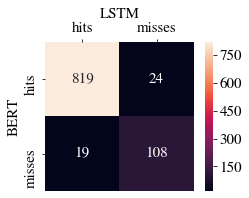

In [58]:
multi_seed = True
# multi_seed = False
task = "Sara"
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
mtrxs = []
for s in ([""] if not multi_seed else seeds["BERT"]):
    mtrx = np.zeros((2,2)) # rows: BERT, cols: LSTM
    # both hits
    mtrx[0,0] = len(data[(data["label"] == data["pred_LSTM" + s]) & (data["label"] == data["pred_BERT" + s])])
    # both misses
    mtrx[1,1] = len(data[(data["label"] != data["pred_LSTM" + s]) & (data["label"] != data["pred_BERT" + s])])
    # BERT hits, LSTM misses
    mtrx[0,1] = len(data[(data["label"] != data["pred_LSTM" + s]) & (data["label"] == data["pred_BERT" + s])])
    # BERT misses, LSTM hits
    mtrx[1,0] = len(data[(data["label"] == data["pred_LSTM" + s]) & (data["label"] != data["pred_BERT" + s])])
    mtrxs.append(mtrx)
mtrxs = np.array(mtrxs)

fig = plt.figure(figsize=(4, 3))
ax = plt.gca()
sns.heatmap(mtrxs.mean(axis=0), annot=True, fmt=".0f", xticklabels=["hits", "misses"], yticklabels=["hits", "misses"], ax=ax, square=True)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xlabel("LSTM")
ax.set_ylabel("BERT")
fig.tight_layout()
plt.show()
fig.savefig("img/hits-mistakes-overlap{}-{}.png".format("(multiseed)" if multi_seed else "", task))

## Overlap of hits/misses for all 3 models.

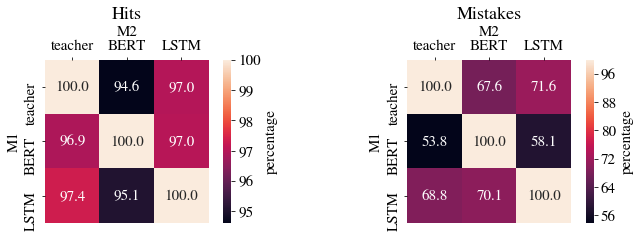

In [39]:
# multi_seed = True
multi_seed = False
task = "SST-2"
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
mtrxs_hits = []
mtrxs_misses = []
for s in ([""] if not multi_seed else seeds["BERT"]):
    mtrx_hits = np.zeros((3, 3))
    mtrx_misses = np.zeros((3, 3))
    for i, m1 in enumerate(model_types):
        for j, m2 in enumerate(model_types):
            # hits of m1 AND m2 divided by hits of m1
            N_m1 = len(data[(data["label"] == data["pred_{}".format(m1) + s])])
            N_both = len(data[(data["label"] == data["pred_{}".format(m1) + s]) & (data["label"] == data["pred_{}".format(m2) + s])])
            mtrx_hits[i, j] = N_both/N_m1
            
            # mises of m1 AND m2 divided by misses of m1
            N_m1 = len(data[(data["label"] != data["pred_{}".format(m1) + s])])
            N_both = len(data[(data["label"] != data["pred_{}".format(m1) + s]) & (data["label"] != data["pred_{}".format(m2) + s])])
            mtrx_misses[i, j] = N_both/N_m1
    mtrxs_hits.append(mtrx_hits)
    mtrxs_misses.append(mtrx_misses)
mtrxs_hits = np.array(mtrxs_hits)*100
mtrxs_misses = np.array(mtrxs_misses)*100

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
for ax, title, mtrx in zip(axs, ["Hits", "Mistakes"], [mtrxs_hits, mtrxs_misses]):
    sns.heatmap(mtrx.mean(axis=0), annot=True, fmt=".1f", xticklabels=model_types, yticklabels=model_types, 
                ax=ax, square=True, cbar_kws={"label": "percentage"})
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel("M2")
    ax.set_ylabel("M1")
    ax.set_title(title)
fig.tight_layout(w_pad=2)
plt.show()
fig.savefig("img/hits-mistakes-overlap-all{}-{}.png".format("(multiseed)" if multi_seed else "", task))

# Exploring knowledge distillation

In [5]:
task = "Sara"

## Cases where teacher is confident but both students are unconfident

In [6]:
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
data = decode_labels(data, task)
confidence_diff = (data["confidence_teacher"] - data["confidence_BERT"])/2 + \
                  (data["confidence_teacher"] - data["confidence_LSTM"])/2

data = data.merge(confidence_diff.rename("diff"), left_index=True, right_index=True)
data = data.rename(columns={"confidence_{}".format(m): "c_{}".format(m[:1]) for m in model_types})
data = data.rename(columns={"pred_{}".format(m): "{}".format(m) for m in model_types})
data = data[["sentence", "label", "teacher", "c_t", "LSTM", "c_L", "BERT", "c_B", "diff"]]

N = 10
data = data.sort_values(by=["diff"], ascending=False)[:N]
colourcode_confidences(data)

,sentence,label,teacher,c_t,LSTM,c_L,BERT,c_B,diff
429,i decline,deny,deny,0.98,deny,0.34,out_of_scope,0.27,0.675
474,"able to integrate with paypal, wordpress, facebook andd twilio",enter_data,enter_data,0.98,enter_data,0.36,technical_question,0.44,0.58
350,you live around here?,ask_wherefrom,ask_wherefrom,0.97,ask_wherefrom,0.46,ask_wherefrom,0.32,0.58
214,whatchcha doing,ask_howdoing,ask_whatspossible,0.94,out_of_scope,0.31,ask_howdoing,0.42,0.575
385,tlak to you later,bye,bye,0.93,react_positive,0.35,bye,0.47,0.52
239,are you bilingual?,ask_languagesbot,ask_languagesbot,0.98,ask_languagesbot,0.59,out_of_scope,0.34,0.515
648,halo,greet,greet,0.99,greet,0.36,greet,0.62,0.5
190,you originated through what means?,ask_howbuilt,ask_howbuilt,0.89,ask_whatisrasa,0.12,out_of_scope,0.67,0.495
751,i have chosen rasa stack,install_rasa,install_rasa,0.98,install_rasa,0.68,install_rasa,0.3,0.49
655,you're the most moronic person i know,handleinsult,handleinsult,0.99,out_of_scope,0.57,out_of_scope,0.47,0.47


## Cases where teacher is right but both students are wrong

In [7]:
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
data = decode_labels(data, task)
data = data[data["label"] == data["pred_teacher"]]
data = data[(data["label"] != data["pred_BERT"]) & (data["label"] != data["pred_LSTM"])]
data = data.rename(columns={"confidence_{}".format(m): "c_{}".format(m[:1]) for m in model_types})
data = data.rename(columns={"pred_{}".format(m): "{}".format(m) for m in model_types})
data = data.sort_values(by=["label"])
data = data[["sentence", "label", "teacher", "c_t", "LSTM", "c_L", "BERT", "c_B"]]
N = 10
data = shuffle(data, random_state=42, n_samples=N)
colourcode_confidences(data)

,sentence,label,teacher,c_t,LSTM,c_L,BERT,c_B
658,u r a piece of junk,handleinsult,handleinsult,0.99,enter_data,0.88,react_positive,0.38
817,what is todays date,out_of_scope,out_of_scope,0.29,ask_weather,0.93,ask_weather,0.27
46,fuck yeah!,affirm,affirm,0.99,handleinsult,0.81,handleinsult,0.96
866,who is the president of india ?,out_of_scope,out_of_scope,0.64,ask_builder,0.63,ask_builder,0.58
374,whom i talking to,ask_whoisit,ask_whoisit,0.65,human_handoff,0.9,human_handoff,0.55
655,you're the most moronic person i know,handleinsult,handleinsult,0.99,out_of_scope,0.57,out_of_scope,0.47
208,como estas,ask_howdoing,ask_howdoing,0.96,out_of_scope,0.88,enter_data,0.87
190,you originated through what means?,ask_howbuilt,ask_howbuilt,0.89,ask_whatisrasa,0.12,out_of_scope,0.67
944,what is the last version of rasa core?,technical_question,technical_question,0.26,ask_whatisrasa,0.28,ask_whatisrasa,0.44
317,talk to me!,ask_whatspossible,ask_whatspossible,0.45,human_handoff,0.65,human_handoff,0.42


# Mistake type analysis for CoLA

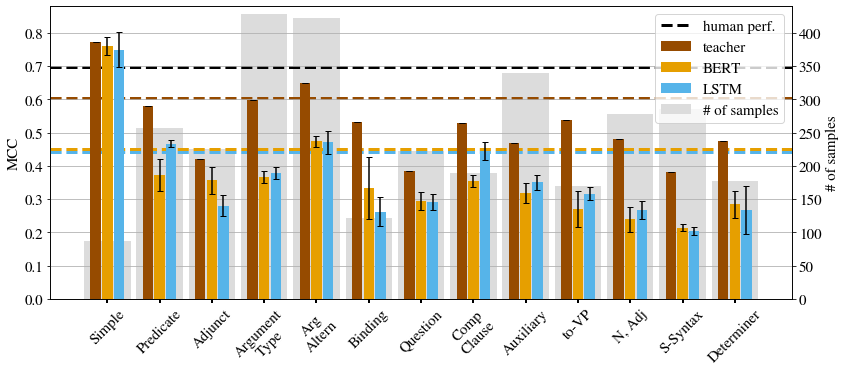

In [20]:
multi_seed = True
data = pd.read_csv("predictions/full_predictions-CoLA.csv")
cols_major_nice = ["Simple", "Predicate", "Adjunct", "Argument\nType", "Arg\nAltern", "Binding", "Question", "Comp\nClause", "Auxiliary", "to-VP", "N, Adj", "S-Syntax", "Determiner"]
fig = plt.figure(figsize=(12, 5.5))
ax = plt.gca()
ax2 = ax.twinx()
xticks = np.arange(len(cols_major))
results = {}
amounts = {}
N = len(data)
for i, model_type in enumerate(model_types):
    results[model_type] = []
    for c in cols_major:
        model_results = []
        for s in (seeds[model_type] if multi_seed else [""]):
            model_type_seed = model_type + s        
            pred_col = "pred_" + model_type_seed            
            rows = data[data["annot_major"].apply(lambda r: c in r)]
            amounts[c] = len(rows)
            mcc = matthews_corrcoef(rows["label"], rows[pred_col])
            model_results.append(mcc)
        results[model_type].append((np.mean(model_results), np.std(model_results)))
    means = np.array(results[model_type])[:,0]
    stds = np.array(results[model_type])[:,1]
    ax.bar(xticks*4.5-1+i, means, yerr=stds, width=0.9, color=model_colours[model_type], zorder=2, 
           label=model_type, capsize=3)
    mcc = matthews_corrcoef(data["label"], data["pred_" + model_type])
    ax.axhline(mcc, linestyle="--", lw=3, zorder=0, c=model_colours[model_type])
ax2.bar(xticks*4.5, [amounts[c] for c in cols_major], width=4, zorder=1, color=[220/255]*3, label="# of samples")
ax.axhline(0.697, label="human perf.", linestyle="--", lw=3, zorder=0, c="black")
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.set_xticks(xticks*4.5)
ax.set_xticklabels(cols_major_nice)
ax.set_ylabel("MCC")
ax.set_ylim(0,0.88)
ax2.set_ylim(0,440)
ax2.set_ylabel("# of samples")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax.tick_params(axis="x", length=4, width=2, rotation=45)
ax.grid(axis="y")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()
fig.savefig("img/CoLA-annots_major{}.png".format("(multiseed)" if multi_seed else ""))

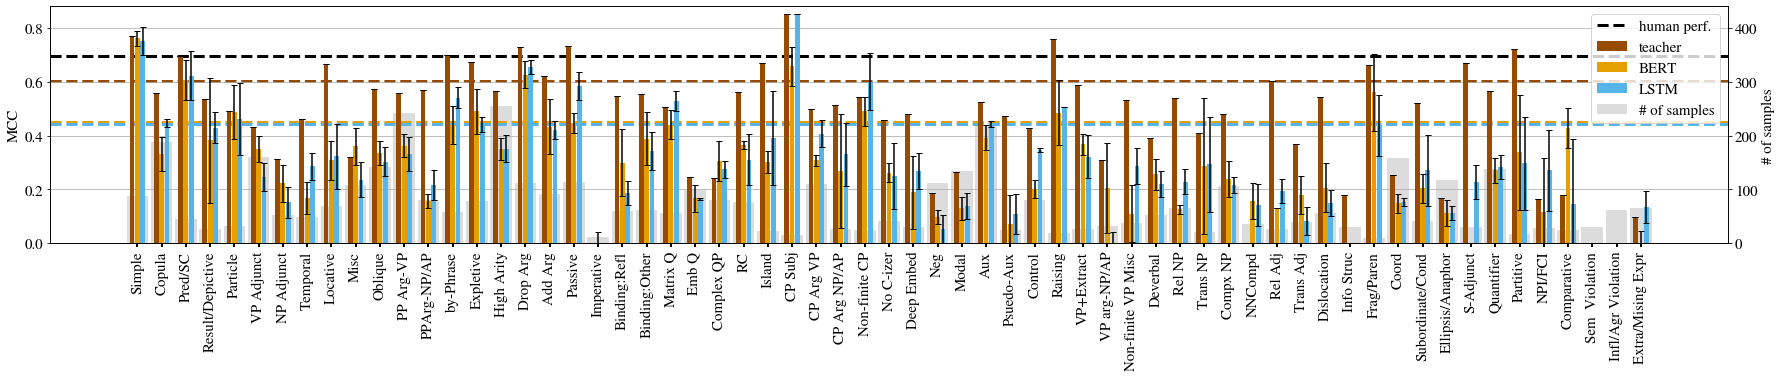

In [22]:
multi_seed = True
data = pd.read_csv("predictions/full_predictions-CoLA.csv")
fig = plt.figure(figsize=(25, 5.5))
ax = plt.gca()
ax2 = ax.twinx()
xticks = np.arange(len(cols_minor))
results = {}
amounts = {}
N = len(data)
for i, model_type in enumerate(model_types):
    results[model_type] = []
    for c in cols_minor:
        model_results = []
        for s in (seeds[model_type] if multi_seed else [""]):
            model_type_seed = model_type + s        
            pred_col = "pred_" + model_type_seed            
            rows = data[data["annot_minor"].apply(lambda r: c in r)]
            amounts[c] = len(rows)
            mcc = matthews_corrcoef(rows["label"], rows[pred_col])
            model_results.append(mcc)
        results[model_type].append((np.mean(model_results), np.std(model_results)))
    means = np.array(results[model_type])[:,0]
    stds = np.array(results[model_type])[:,1]
    ax.bar(xticks*4.5-1+i, means, yerr=stds, width=0.9, color=model_colours[model_type], zorder=2, 
           label=model_type, capsize=3)
    mcc = matthews_corrcoef(data["label"], data["pred_" + model_type])
    ax.axhline(mcc, linestyle="--", lw=3, zorder=0, c=model_colours[model_type])
ax2.bar(xticks*4.5, [amounts[c] for c in cols_minor], width=4, zorder=1, color=[220/255]*3, label="# of samples")
ax.axhline(0.697, label="human perf.", linestyle="--", lw=3, zorder=0, c="black")
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.set_xticks(xticks*4.5)
ax.set_xticklabels(cols_minor)
ax.set_ylabel("MCC")
ax.set_ylim(0,0.88)
ax2.set_ylim(0,440)
ax2.set_ylabel("# of samples")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax.tick_params(axis="x", length=4, width=2, rotation=90)
ax.grid(axis="y")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()
fig.savefig("img/CoLA-annots_minor{}.png".format("(multiseed)" if multi_seed else ""))

## Categories where LSTM is better

In [30]:
N = 10
cats = ["Copula", "Passive", "Compx NP", "Quantifier"]
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
data = decode_labels(data, task)
data = data[(data["label"] != data["pred_BERT"]) & (data["label"] == data["pred_LSTM"])]
data = data.rename(columns={"confidence_{}".format(m): "c_{}".format(m[:1]) for m in model_types})
data = data.rename(columns={"pred_{}".format(m): "{}".format(m) for m in model_types})
for c in cats:
    rows = data[data["annot_minor"].apply(lambda r: c in r)]
    print("{}: ({}x)".format(c, len(rows)))
    rows = shuffle(rows, random_state=42, n_samples=min(N, len(rows)))
    display(colourcode_confidences(rows))

Copula: (15x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
587,it has been determined that somebody will be appointed; it's just not clear yet who.,0,1,0.98,1,0.96,0,0.85,"['Predicate', 'Argument Type', 'Arg Altern', 'Question', 'Comp Clause', 'Auxiliary', 'N, Adj', 'S-Syntax', 'Determiner']","['Copula', 'Expletive', 'Drop Arg', 'Add Arg', 'Passive', 'Emb Q', 'CP Arg VP', 'Neg', 'Aux', 'Trans Adj', 'Coord', 'Quantifier', 'NPI/FCI']"
694,i wonder what to be a clown on the cover of.,0,0,0.84,1,0.7,0,0.56,"['Predicate', 'Adjunct', 'Argument Type', 'Question', 'to-VP', 'N, Adj']","['Copula', 'VP Adjunct', 'NP Adjunct', 'Locative', 'PPArg-NP/AP', 'Emb Q', 'Island', 'VP+Extract', 'Rel NP']"
32,what the water did to the bottle was fill it.,0,1,0.97,1,0.97,0,0.59,"['Predicate', 'Binding', 'Question', 'to-VP', 'N, Adj', 'S-Syntax']","['Copula', 'Binding:Other', 'Emb Q', 'Non-finite VP Misc', 'Deverbal', 'Info Struc']"
1013,john felt it that bill was tardy.,0,0,0.92,1,0.82,0,0.86,"['Predicate', 'Argument Type', 'Arg Altern', 'Comp Clause']","['Copula', 'Expletive', 'High Arity', 'Add Arg', 'CP Arg VP']"
263,most of the fruit is rotten.,1,1,0.98,0,0.59,1,0.95,"['Predicate', 'Determiner']","['Copula', 'Quantifier', 'Partitive']"
330,"because she's so pleasant, as for mary i really like her.",0,0,0.85,1,0.91,0,0.53,"['Predicate', 'Binding', 'S-Syntax']","['Copula', 'Binding:Other', 'Dislocation', 'Info Struc', 'Subordinate/Cond', 'S-Adjunct']"
82,the proof this set is recursive is difficult.,0,0,0.85,1,0.97,0,0.89,"['Predicate', 'Comp Clause', 'N, Adj']","['Copula', 'CP Arg NP/AP', 'No C-izer', 'Trans NP']"
33,what the water did to the whole bottle was fill it.,0,1,0.89,1,0.97,0,0.79,"['Predicate', 'Argument Type', 'Question', 'to-VP', 'N, Adj', 'S-Syntax', 'Violations']","['Copula', 'PP Arg-VP', 'Emb Q', 'Non-finite VP Misc', 'Deverbal', 'Info Struc', 'Sem Violation']"
1016,that john is reluctant seems.,0,0,0.94,1,0.94,0,0.86,"['Predicate', 'Arg Altern', 'Comp Clause', 'Violations']","['Copula', 'Drop Arg', 'CP Subj', 'Extra/Mising Expr']"
255,that fred was unpopular nominated bill.,0,0,0.95,1,0.96,0,0.88,"['Predicate', 'Comp Clause', 'Violations']","['Copula', 'CP Subj', 'Sem Violation']"


Passive: (12x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
926,the cat were bitten by the dog.,0,1,0.98,1,0.62,0,0.5,"['Argument Type', 'Arg Altern', 'Auxiliary', 'Violations']","['by-Phrase', 'Passive', 'Aux', 'Infl/Agr Violation']"
915,chris was handed sandy a note.,0,0,0.83,1,0.98,0,0.93,"['Argument Type', 'Arg Altern', 'Auxiliary', 'Violations']","['Oblique', 'High Arity', 'Passive', 'Aux', 'Extra/Mising Expr']"
54,mary came to be introduced by the bartender and i also came to be.,0,0,0.92,1,0.62,0,0.8,"['Argument Type', 'Arg Altern', 'Auxiliary', 'to-VP', 'S-Syntax']","['by-Phrase', 'Passive', 'Psuedo-Aux', 'Control', 'Coord', 'Ellipsis/Anaphor']"
913,chris was handed sandy a note by pat.,0,1,0.94,1,0.98,0,0.93,"['Argument Type', 'Arg Altern', 'Violations']","['Oblique', 'by-Phrase', 'High Arity', 'Add Arg', 'Passive', 'Extra/Mising Expr']"
617,john was spoken to by mary.,1,1,0.98,0,0.62,1,0.62,"['Argument Type', 'Arg Altern', 'Auxiliary']","['PP Arg-VP', 'by-Phrase', 'Passive', 'Aux']"
587,it has been determined that somebody will be appointed; it's just not clear yet who.,0,1,0.98,1,0.96,0,0.85,"['Predicate', 'Argument Type', 'Arg Altern', 'Question', 'Comp Clause', 'Auxiliary', 'N, Adj', 'S-Syntax', 'Determiner']","['Copula', 'Expletive', 'Drop Arg', 'Add Arg', 'Passive', 'Emb Q', 'CP Arg VP', 'Neg', 'Aux', 'Trans Adj', 'Coord', 'Quantifier', 'NPI/FCI']"
298,a pound was weighed by the book.,0,0,0.86,1,0.97,0,0.84,"['Predicate', 'Argument Type', 'Arg Altern', 'Auxiliary']","['Copula', 'by-Phrase', 'Add Arg', 'Passive', 'Aux']"
973,bill was struck by john as stupid.,0,0,0.94,1,0.64,0,0.89,"['Predicate', 'Argument Type', 'Arg Altern', 'Auxiliary']","['Pred/SC', 'PP Arg-VP', 'by-Phrase', 'Passive', 'Aux']"
616,the paper was written by john up.,0,1,0.89,1,0.79,0,0.85,"['Adjunct', 'Argument Type', 'Arg Altern']","['Particle', 'by-Phrase', 'High Arity', 'Passive']"
676,"because steve's of a spider's eye had been stolen, i borrowed fred's diagram of a snake's fang.",0,0,0.85,1,0.73,0,0.85,"['Argument Type', 'Arg Altern', 'Auxiliary', 'N, Adj', 'S-Syntax']","['PPArg-NP/AP', 'Drop Arg', 'Passive', 'Aux', 'Rel NP', 'Dislocation', 'Subordinate/Cond', 'Ellipsis/Anaphor', 'S-Adjunct']"


Compx NP: (8x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
307,jack is the person with whom jenny fell in love with.,0,1,0.98,1,0.98,0,0.71,"['Predicate', 'Argument Type', 'Arg Altern', 'Question', 'N, Adj', 'Violations']","['Copula', 'Oblique', 'PP Arg-VP', 'High Arity', 'Complex QP', 'RC', 'Compx NP', 'Extra/Mising Expr']"
685,the book what inspired them was very long.,0,0,0.77,1,0.89,0,0.8,"['Predicate', 'Question', 'N, Adj']","['Copula', 'RC', 'Compx NP']"
291,"as a statesman, scarcely could he do anything worth mentioning.",1,1,0.94,0,0.9,1,0.87,"['Predicate', 'Adjunct', 'Auxiliary', 'to-VP', 'N, Adj', 'S-Syntax', 'Determiner']","['Pred/SC', 'NP Adjunct', 'Modal', 'VP+Extract', 'VP arg-NP/AP', 'Compx NP', 'Trans Adj', 'Dislocation', 'S-Adjunct', 'Quantifier', 'NPI/FCI']"
727,the only person whose kids dana is willing to put up with is pat.,1,1,0.96,0,0.91,1,0.89,"['Predicate', 'Adjunct', 'Argument Type', 'Question', 'Auxiliary', 'to-VP', 'N, Adj']","['Copula', 'Particle', 'PP Arg-VP', 'Complex QP', 'RC', 'Psuedo-Aux', 'VP arg-NP/AP', 'Compx NP', 'Trans Adj']"
348,they chased the man with the car.,1,1,0.98,0,0.56,1,0.97,"['Adjunct', 'N, Adj']","['VP Adjunct', 'NP Adjunct', 'Misc', 'Compx NP']"
564,"they were going to meet sometime on sunday, but the faculty didn't know when.",1,1,0.98,0,0.87,1,0.76,"['Adjunct', 'Question', 'Auxiliary', 'N, Adj', 'S-Syntax', 'Determiner']","['VP Adjunct', 'NP Adjunct', 'Temporal', 'Emb Q', 'Neg', 'Aux', 'Compx NP', 'Coord', 'Quantifier']"
362,heidi thinks that andy to eat salmon flavored candy bars.,0,0,0.95,1,0.87,0,0.89,"['Comp Clause', 'N, Adj']","['CP Arg VP', 'Non-finite CP', 'Compx NP']"
714,i dislike the people in who we placed our trust.,0,0,0.83,1,0.66,0,0.88,"['Argument Type', 'Arg Altern', 'Binding', 'Question', 'N, Adj']","['Oblique', 'PP Arg-VP', 'High Arity', 'Binding:Other', 'Complex QP', 'RC', 'Compx NP']"


Quantifier: (10x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
587,it has been determined that somebody will be appointed; it's just not clear yet who.,0,1,0.98,1,0.96,0,0.85,"['Predicate', 'Argument Type', 'Arg Altern', 'Question', 'Comp Clause', 'Auxiliary', 'N, Adj', 'S-Syntax', 'Determiner']","['Copula', 'Expletive', 'Drop Arg', 'Add Arg', 'Passive', 'Emb Q', 'CP Arg VP', 'Neg', 'Aux', 'Trans Adj', 'Coord', 'Quantifier', 'NPI/FCI']"
51,"we wanted to invite someone, but we couldn't decide who to.",0,0,0.86,1,0.95,0,0.55,"['Question', 'to-VP', 'S-Syntax', 'Determiner', 'Violations']","['Emb Q', 'Control', 'Coord', 'Ellipsis/Anaphor', 'Quantifier', 'Extra/Mising Expr']"
466,everyone hopes everyone to sleep.,0,0,0.95,1,0.98,0,0.73,"['Arg Altern', 'to-VP', 'Determiner', 'Violations']","['High Arity', 'Add Arg', 'Control', 'Quantifier', 'Extra/Mising Expr']"
38,"most people probably consider, even though the courts didn't actually find, klaus guilty of murder.",1,1,0.97,0,0.69,1,0.61,"['Predicate', 'Argument Type', 'Arg Altern', 'Auxiliary', 'N, Adj', 'S-Syntax', 'Determiner']","['Pred/SC', 'PPArg-NP/AP', 'High Arity', 'Neg', 'Aux', 'Rel Adj', 'Subordinate/Cond', 'Ellipsis/Anaphor', 'S-Adjunct', 'Quantifier']"
564,"they were going to meet sometime on sunday, but the faculty didn't know when.",1,1,0.98,0,0.87,1,0.76,"['Adjunct', 'Question', 'Auxiliary', 'N, Adj', 'S-Syntax', 'Determiner']","['VP Adjunct', 'NP Adjunct', 'Temporal', 'Emb Q', 'Neg', 'Aux', 'Compx NP', 'Coord', 'Quantifier']"
263,most of the fruit is rotten.,1,1,0.98,0,0.59,1,0.95,"['Predicate', 'Determiner']","['Copula', 'Quantifier', 'Partitive']"
846,the report that crime was declining surprised many people.,1,1,0.98,0,0.9,1,0.93,"['Comp Clause', 'N, Adj', 'Determiner']","['CP Arg NP/AP', 'Trans NP', 'Quantifier']"
291,"as a statesman, scarcely could he do anything worth mentioning.",1,1,0.94,0,0.9,1,0.87,"['Predicate', 'Adjunct', 'Auxiliary', 'to-VP', 'N, Adj', 'S-Syntax', 'Determiner']","['Pred/SC', 'NP Adjunct', 'Modal', 'VP+Extract', 'VP arg-NP/AP', 'Compx NP', 'Trans Adj', 'Dislocation', 'S-Adjunct', 'Quantifier', 'NPI/FCI']"
265,i drank some of water.,0,0,0.78,1,0.96,0,0.82,"['Determiner', 'Violations']","['Quantifier', 'Partitive', 'Extra/Mising Expr']"
554,"the newspaper has reported that they are about to appoint someone, but i can't remember who the newspaper has reported that they are about to appoint.",1,1,0.98,0,0.58,1,0.92,"['Question', 'Comp Clause', 'Auxiliary', 'to-VP', 'S-Syntax', 'Determiner']","['Emb Q', 'Island', 'CP Arg VP', 'Deep Embed', 'Neg', 'Modal', 'Psuedo-Aux', 'Control', 'Coord', 'Quantifier']"


## Categories where BERT is better

In [8]:
task = "CoLA"
N = 10
cats = ["VP Adjunct", "Misc", "Oblique", "PP Arg-VP", "High Arity", "Add Arg"]
data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
data = decode_labels(data, task)
data = data[(data["label"] == data["pred_BERT"]) & (data["label"] != data["pred_LSTM"])]
data = data.rename(columns={"confidence_{}".format(m): "c_{}".format(m[:1]) for m in model_types})
data = data.rename(columns={"pred_{}".format(m): "{}".format(m) for m in model_types})
for c in cats:
    rows = data[data["annot_minor"].apply(lambda r: c in r)]
    print("{}: ({}x)".format(c, len(rows)))
    rows = shuffle(rows, random_state=42, n_samples=min(N, len(rows)))
    display(colourcode_confidences(rows))

VP Adjunct: (19x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
40,"clearly, john probably will immediately learn french perfectly.",1,1,0.97,1,0.71,0,0.5,"['Adjunct', 'Auxiliary', 'S-Syntax']","['VP Adjunct', 'Modal', 'S-Adjunct']"
297,the bed was slept in.,1,1,0.98,1,0.94,0,0.81,"['Adjunct', 'Arg Altern']","['VP Adjunct', 'Locative', 'Drop Arg', 'Passive']"
544,joan ate dinner with someone but i don't know who with.,1,0,0.86,1,0.92,0,0.86,"['Adjunct', 'Question', 'S-Syntax', 'Determiner']","['VP Adjunct', 'Misc', 'Emb Q', 'Complex QP', 'Coord', 'Ellipsis/Anaphor', 'Quantifier']"
121,everybody around here who ever buys anything on credit talks in his sleep.,1,1,0.97,1,0.76,0,0.52,"['Adjunct', 'Binding', 'Question', 'N, Adj', 'Determiner']","['VP Adjunct', 'Misc', 'Binding:Other', 'RC', 'Compx NP', 'Quantifier', 'NPI/FCI']"
411,he left the train with somebody else's wallet in his pocket.,1,1,0.98,1,0.86,0,0.87,"['Predicate', 'Adjunct', 'Binding', 'Determiner']","['Result/Depictive', 'VP Adjunct', 'Misc', 'Binding:Other', 'Quantifier']"
1011,john believes it sincerely that bill is here.,0,1,0.98,0,0.78,1,0.89,"['Predicate', 'Adjunct', 'Argument Type', 'Arg Altern', 'Comp Clause', 'S-Syntax']","['Copula', 'VP Adjunct', 'Misc', 'Expletive', 'High Arity', 'Add Arg', 'CP Arg VP', 'Dislocation']"
205,a grandfather clock ticked in the hallway.,1,1,0.98,1,0.86,0,0.85,"['Adjunct', 'N, Adj']","['VP Adjunct', 'Locative', 'NNCompd']"
592,"clinton is anxious to find out which budget dilemmas panetta would be willing to tackle in a certain way, but he won't say in which.",1,1,0.97,1,0.59,0,0.8,"['Predicate', 'Adjunct', 'Arg Altern', 'Question', 'Comp Clause', 'Auxiliary', 'to-VP', 'N, Adj', 'S-Syntax']","['Copula', 'Particle', 'VP Adjunct', 'Misc', 'High Arity', 'Emb Q', 'Complex QP', 'Deep Embed', 'Neg', 'Modal', 'Psuedo-Aux', 'Control', 'VP arg-NP/AP', 'NNCompd', 'Trans Adj', 'Coord', 'Ellipsis/Anaphor']"
996,i bought bill a book to read.,1,1,0.97,1,0.93,0,0.85,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Add Arg', 'VP+Extract']"
1028,i gave pete the book to impress.,0,0,0.82,0,0.52,1,0.92,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP', 'Violations']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Drop Arg', 'VP+Extract', 'Extra/Mising Expr']"


Misc: (16x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
121,everybody around here who ever buys anything on credit talks in his sleep.,1,1,0.97,1,0.76,0,0.52,"['Adjunct', 'Binding', 'Question', 'N, Adj', 'Determiner']","['VP Adjunct', 'Misc', 'Binding:Other', 'RC', 'Compx NP', 'Quantifier', 'NPI/FCI']"
138,martha carved the baby a toy out of wood.,1,1,0.98,1,0.94,0,0.89,"['Adjunct', 'Argument Type', 'Arg Altern']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Add Arg']"
411,he left the train with somebody else's wallet in his pocket.,1,1,0.98,1,0.86,0,0.87,"['Predicate', 'Adjunct', 'Binding', 'Determiner']","['Result/Depictive', 'VP Adjunct', 'Misc', 'Binding:Other', 'Quantifier']"
1028,i gave pete the book to impress.,0,0,0.82,0,0.52,1,0.92,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP', 'Violations']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Drop Arg', 'VP+Extract', 'Extra/Mising Expr']"
1011,john believes it sincerely that bill is here.,0,1,0.98,0,0.78,1,0.89,"['Predicate', 'Adjunct', 'Argument Type', 'Arg Altern', 'Comp Clause', 'S-Syntax']","['Copula', 'VP Adjunct', 'Misc', 'Expletive', 'High Arity', 'Add Arg', 'CP Arg VP', 'Dislocation']"
703,"mary asked me if, in st. louis, john could rent a house cheap.",1,1,0.61,1,0.7,0,0.87,"['Adjunct', 'Arg Altern', 'Question', 'Auxiliary', 'S-Syntax']","['VP Adjunct', 'Misc', 'High Arity', 'Emb Q', 'Modal', 'Dislocation', 'Frag/Paren']"
580,"she was dancing with somebody, but i don't know who with.",1,0,0.87,1,0.9,0,0.81,"['Adjunct', 'Question', 'Auxiliary', 'S-Syntax']","['VP Adjunct', 'Misc', 'Emb Q', 'Complex QP', 'Neg', 'Aux', 'Coord', 'Ellipsis/Anaphor']"
592,"clinton is anxious to find out which budget dilemmas panetta would be willing to tackle in a certain way, but he won't say in which.",1,1,0.97,1,0.59,0,0.8,"['Predicate', 'Adjunct', 'Arg Altern', 'Question', 'Comp Clause', 'Auxiliary', 'to-VP', 'N, Adj', 'S-Syntax']","['Copula', 'Particle', 'VP Adjunct', 'Misc', 'High Arity', 'Emb Q', 'Complex QP', 'Deep Embed', 'Neg', 'Modal', 'Psuedo-Aux', 'Control', 'VP arg-NP/AP', 'NNCompd', 'Trans Adj', 'Coord', 'Ellipsis/Anaphor']"
327,it isn't because sue said anything bad about me that i'm angry.,1,0,0.92,1,0.91,0,0.82,"['Predicate', 'Adjunct', 'Argument Type', 'Arg Altern', 'Comp Clause', 'Auxiliary', 'S-Syntax']","['Copula', 'VP Adjunct', 'Misc', 'Expletive', 'High Arity', 'Add Arg', 'CP Arg VP', 'Neg', 'Subordinate/Cond', 'S-Adjunct']"
1030,i presented it to bill to read.,1,1,0.97,1,0.97,0,0.78,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP']","['VP Adjunct', 'Misc', 'Oblique', 'PP Arg-VP', 'High Arity', 'VP+Extract']"


Oblique: (18x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
74,he attributed to a short circuit which was caused by an overloaded transducer the fire which destroyed most of my factory.,1,1,0.84,1,0.69,0,0.75,"['Argument Type', 'Arg Altern', 'Question', 'N, Adj', 'S-Syntax', 'Determiner']","['Oblique', 'PP Arg-VP', 'by-Phrase', 'High Arity', 'Passive', 'RC', 'Compx NP', 'Dislocation', 'Quantifier', 'Partitive']"
129,sam offered the ball out of the basket.,0,0,0.91,0,0.87,1,0.68,"['Argument Type', 'Arg Altern']","['Oblique', 'PP Arg-VP', 'High Arity']"
698,i wonder in whom to place my trust.,1,1,0.68,1,0.72,0,0.89,"['Argument Type', 'Arg Altern', 'Question', 'to-VP']","['Oblique', 'PP Arg-VP', 'High Arity', 'Emb Q', 'Complex QP', 'VP+Extract']"
632,the magazines were sent by mary to herself.,1,0,0.76,1,0.78,0,0.64,"['Argument Type', 'Arg Altern', 'Binding']","['Oblique', 'PP Arg-VP', 'by-Phrase', 'High Arity', 'Passive', 'Binding:Refl']"
458,mary revealed himself to john.,0,0,0.92,0,0.74,1,0.92,"['Argument Type', 'Arg Altern', 'Binding', 'Violations']","['Oblique', 'PP Arg-VP', 'High Arity', 'Binding:Refl', 'Infl/Agr Violation']"
1004,john left us orders to follow pete.,1,0,0.86,1,0.96,0,0.89,"['Argument Type', 'Arg Altern', 'to-VP', 'N, Adj']","['Oblique', 'High Arity', 'VP arg-NP/AP', 'Deverbal', 'Trans NP']"
1030,i presented it to bill to read.,1,1,0.97,1,0.97,0,0.78,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP']","['VP Adjunct', 'Misc', 'Oblique', 'PP Arg-VP', 'High Arity', 'VP+Extract']"
1028,i gave pete the book to impress.,0,0,0.82,0,0.52,1,0.92,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP', 'Violations']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Drop Arg', 'VP+Extract', 'Extra/Mising Expr']"
906,lou hoped the umbrella in the closet.,0,0,0.96,0,0.89,1,0.61,"['Predicate', 'Argument Type', 'Arg Altern', 'Violations']","['Pred/SC', 'Oblique', 'PP Arg-VP', 'High Arity', 'Sem Violation']"
138,martha carved the baby a toy out of wood.,1,1,0.98,1,0.94,0,0.89,"['Adjunct', 'Argument Type', 'Arg Altern']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Add Arg']"


PP Arg-VP: (25x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
548,"she said she had spoken to everybody, but he wasn't sure who.",0,1,0.97,0,0.84,1,0.55,"['Argument Type', 'Question', 'Comp Clause', 'Auxiliary', 'N, Adj', 'S-Syntax']","['PP Arg-VP', 'Emb Q', 'CP Arg VP', 'CP Arg NP/AP', 'No C-izer', 'Aux', 'Trans Adj', 'Coord', 'Ellipsis/Anaphor']"
725,the only person whose kids dana is willing to put up with was written by john.,0,1,0.77,0,0.81,1,0.96,"['Predicate', 'Adjunct', 'Argument Type', 'Arg Altern', 'Question', 'Auxiliary', 'to-VP', 'N, Adj', 'Violations']","['Copula', 'Particle', 'PP Arg-VP', 'by-Phrase', 'High Arity', 'Passive', 'Complex QP', 'RC', 'Aux', 'Psuedo-Aux', 'VP arg-NP/AP', 'Compx NP', 'Trans Adj', 'Sem Violation']"
74,he attributed to a short circuit which was caused by an overloaded transducer the fire which destroyed most of my factory.,1,1,0.84,1,0.69,0,0.75,"['Argument Type', 'Arg Altern', 'Question', 'N, Adj', 'S-Syntax', 'Determiner']","['Oblique', 'PP Arg-VP', 'by-Phrase', 'High Arity', 'Passive', 'RC', 'Compx NP', 'Dislocation', 'Quantifier', 'Partitive']"
1030,i presented it to bill to read.,1,1,0.97,1,0.97,0,0.78,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP']","['VP Adjunct', 'Misc', 'Oblique', 'PP Arg-VP', 'High Arity', 'VP+Extract']"
690,i wonder to whom they dedicated the building.,1,1,0.97,1,0.85,0,0.69,"['Argument Type', 'Arg Altern', 'Question']","['Oblique', 'PP Arg-VP', 'High Arity', 'Emb Q', 'Complex QP']"
586,"the ta's have been arguing about whether some student or other should pass, but i can't now remember which one.",1,1,0.97,1,0.72,0,0.61,"['Argument Type', 'Question', 'Auxiliary', 'S-Syntax']","['PP Arg-VP', 'Emb Q', 'Neg', 'Modal', 'Aux', 'Coord', 'Ellipsis/Anaphor']"
698,i wonder in whom to place my trust.,1,1,0.68,1,0.72,0,0.89,"['Argument Type', 'Arg Altern', 'Question', 'to-VP']","['Oblique', 'PP Arg-VP', 'High Arity', 'Emb Q', 'Complex QP', 'VP+Extract']"
75,the mayor regarded as being absurd the proposal to build a sidewalk from dartmouth to smith.,0,1,0.96,0,0.56,1,0.91,"['Predicate', 'Argument Type', 'to-VP', 'N, Adj', 'S-Syntax']","['Pred/SC', 'PP Arg-VP', 'VP arg-NP/AP', 'Deverbal', 'Trans NP', 'Dislocation']"
1024,it was to john that i gave the book.,1,1,0.98,1,0.98,0,0.78,"['Argument Type', 'Arg Altern', 'Comp Clause', 'S-Syntax']","['Oblique', 'PP Arg-VP', 'Expletive', 'High Arity', 'CP Arg VP', 'Info Struc']"
341,"hopefully, we'll make it through the winter without snow.",1,1,0.98,1,0.96,0,0.76,"['Adjunct', 'Argument Type', 'Auxiliary', 'S-Syntax']","['VP Adjunct', 'Misc', 'PP Arg-VP', 'Expletive', 'Modal', 'Dislocation', 'S-Adjunct']"


High Arity: (29x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
1033,john thinks it would upset himself to die.,1,1,0.97,1,0.96,0,0.69,"['Argument Type', 'Arg Altern', 'Binding', 'Comp Clause', 'Auxiliary', 'to-VP']","['Expletive', 'High Arity', 'Add Arg', 'Binding:Refl', 'CP Arg VP', 'No C-izer', 'Modal', 'Control']"
745,we gave presents to ourselves.,1,1,0.98,1,0.95,0,0.62,"['Argument Type', 'Arg Altern', 'Binding']","['Oblique', 'PP Arg-VP', 'High Arity', 'Binding:Refl']"
698,i wonder in whom to place my trust.,1,1,0.68,1,0.72,0,0.89,"['Argument Type', 'Arg Altern', 'Question', 'to-VP']","['Oblique', 'PP Arg-VP', 'High Arity', 'Emb Q', 'Complex QP', 'VP+Extract']"
1009,john regretted it that bill had a good time.,1,0,0.85,1,0.97,0,0.6,"['Argument Type', 'Arg Altern', 'Comp Clause']","['Expletive', 'High Arity', 'Add Arg', 'CP Arg VP']"
592,"clinton is anxious to find out which budget dilemmas panetta would be willing to tackle in a certain way, but he won't say in which.",1,1,0.97,1,0.59,0,0.8,"['Predicate', 'Adjunct', 'Arg Altern', 'Question', 'Comp Clause', 'Auxiliary', 'to-VP', 'N, Adj', 'S-Syntax']","['Copula', 'Particle', 'VP Adjunct', 'Misc', 'High Arity', 'Emb Q', 'Complex QP', 'Deep Embed', 'Neg', 'Modal', 'Psuedo-Aux', 'Control', 'VP arg-NP/AP', 'NNCompd', 'Trans Adj', 'Coord', 'Ellipsis/Anaphor']"
632,the magazines were sent by mary to herself.,1,0,0.76,1,0.78,0,0.64,"['Argument Type', 'Arg Altern', 'Binding']","['Oblique', 'PP Arg-VP', 'by-Phrase', 'High Arity', 'Passive', 'Binding:Refl']"
1004,john left us orders to follow pete.,1,0,0.86,1,0.96,0,0.89,"['Argument Type', 'Arg Altern', 'to-VP', 'N, Adj']","['Oblique', 'High Arity', 'VP arg-NP/AP', 'Deverbal', 'Trans NP']"
23,mickey looked up it.,0,1,0.66,0,0.93,1,0.75,"['Adjunct', 'Arg Altern', 'S-Syntax']","['Particle', 'High Arity', 'Dislocation']"
1030,i presented it to bill to read.,1,1,0.97,1,0.97,0,0.78,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP']","['VP Adjunct', 'Misc', 'Oblique', 'PP Arg-VP', 'High Arity', 'VP+Extract']"
703,"mary asked me if, in st. louis, john could rent a house cheap.",1,1,0.61,1,0.7,0,0.87,"['Adjunct', 'Arg Altern', 'Question', 'Auxiliary', 'S-Syntax']","['VP Adjunct', 'Misc', 'High Arity', 'Emb Q', 'Modal', 'Dislocation', 'Frag/Paren']"


Add Arg: (13x)


,sentence,label,teacher,c_t,BERT,c_B,LSTM,c_L,annot_major,annot_minor
1011,john believes it sincerely that bill is here.,0,1,0.98,0,0.78,1,0.89,"['Predicate', 'Adjunct', 'Argument Type', 'Arg Altern', 'Comp Clause', 'S-Syntax']","['Copula', 'VP Adjunct', 'Misc', 'Expletive', 'High Arity', 'Add Arg', 'CP Arg VP', 'Dislocation']"
996,i bought bill a book to read.,1,1,0.97,1,0.93,0,0.85,"['Adjunct', 'Argument Type', 'Arg Altern', 'to-VP']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Add Arg', 'VP+Extract']"
31,the tub leaked water.,1,1,0.98,1,0.83,0,0.86,['Arg Altern'],['Add Arg']
933,there is a seat available.,1,1,0.97,1,0.96,0,0.68,"['Predicate', 'Arg Altern']","['Copula', 'High Arity', 'Add Arg']"
277,there is believed to be sheep in the park.,0,0,0.78,0,0.52,1,0.88,"['Predicate', 'Argument Type', 'Arg Altern', 'Auxiliary', 'to-VP', 'Violations']","['Copula', 'Expletive', 'Drop Arg', 'Add Arg', 'Passive', 'Aux', 'Raising', 'Infl/Agr Violation']"
206,i squeaked the door.,0,1,0.88,0,0.91,1,0.97,['Arg Altern'],['Add Arg']
138,martha carved the baby a toy out of wood.,1,1,0.98,1,0.94,0,0.89,"['Adjunct', 'Argument Type', 'Arg Altern']","['VP Adjunct', 'Misc', 'Oblique', 'High Arity', 'Add Arg']"
1033,john thinks it would upset himself to die.,1,1,0.97,1,0.96,0,0.69,"['Argument Type', 'Arg Altern', 'Binding', 'Comp Clause', 'Auxiliary', 'to-VP']","['Expletive', 'High Arity', 'Add Arg', 'Binding:Refl', 'CP Arg VP', 'No C-izer', 'Modal', 'Control']"
212,there presented itself a wonderful opportunity yesterday.,0,0,0.86,0,0.9,1,0.52,"['Adjunct', 'Argument Type', 'Arg Altern', 'Binding']","['VP Adjunct', 'Temporal', 'Expletive', 'Add Arg', 'Binding:Refl']"
530,"they're going to serve the guests something, but it's unclear what.",1,1,0.98,1,0.97,0,0.78,"['Argument Type', 'Arg Altern', 'Question', 'Comp Clause', 'Auxiliary', 'to-VP', 'N, Adj', 'S-Syntax', 'Determiner']","['Oblique', 'Expletive', 'High Arity', 'Add Arg', 'Emb Q', 'CP Arg NP/AP', 'Psuedo-Aux', 'Control', 'Trans Adj', 'Coord', 'Ellipsis/Anaphor', 'Quantifier']"


# Playground

In [24]:
data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format("Sara", "LSTM"), delimiter="\t")

## Quick info

In [4]:
data

,sentence,label,pred,certainty_of_pred,certainty_of_label,logits
0,the sailors rode the breeze clear of the rocks.,1,1,0.969,0.969,"-2.0777724,1.3549101"
1,the weights made the rope stretch over the pul...,1,1,0.972,0.972,"-2.1502833,1.4040403"
2,the mechanical doll wriggled itself loose.,1,1,0.960,0.960,"-1.9746174,1.2129471"
3,"if you had eaten more, you would want less.",1,1,0.947,0.947,"-1.8209175,1.0607835"
4,"as you eat the most, you want the least.",0,1,0.856,0.144,"-1.14807,0.6344539"
...,...,...,...,...,...,...
1038,john considers bill silly.,1,1,0.978,0.978,"-2.240571,1.5472332"
1039,john considers bill to be silly.,1,1,0.984,0.984,"-2.3931918,1.72282"
1040,john bought a dog for himself to play with.,0,1,0.760,0.240,"-0.7178209,0.4342072"
1041,john arranged for himself to get the prize.,1,1,0.973,0.973,"-2.1123729,1.4771334"


In [5]:
data.describe()

,label,pred,certainty_of_pred,certainty_of_label
count,1043.000000,1043.000000,1043.000000,1043.000000
mean,0.691275,0.746884,0.891261,0.730762
std,0.462189,0.435005,0.119072,0.337798
min,0.000000,0.000000,0.500000,0.008000
25%,0.000000,0.000000,0.858500,0.561000
50%,1.000000,1.000000,0.941000,0.920000
75%,1.000000,1.000000,0.976000,0.975000
max,1.000000,1.000000,0.992000,0.989000


## Checking peakiness of logit distributions

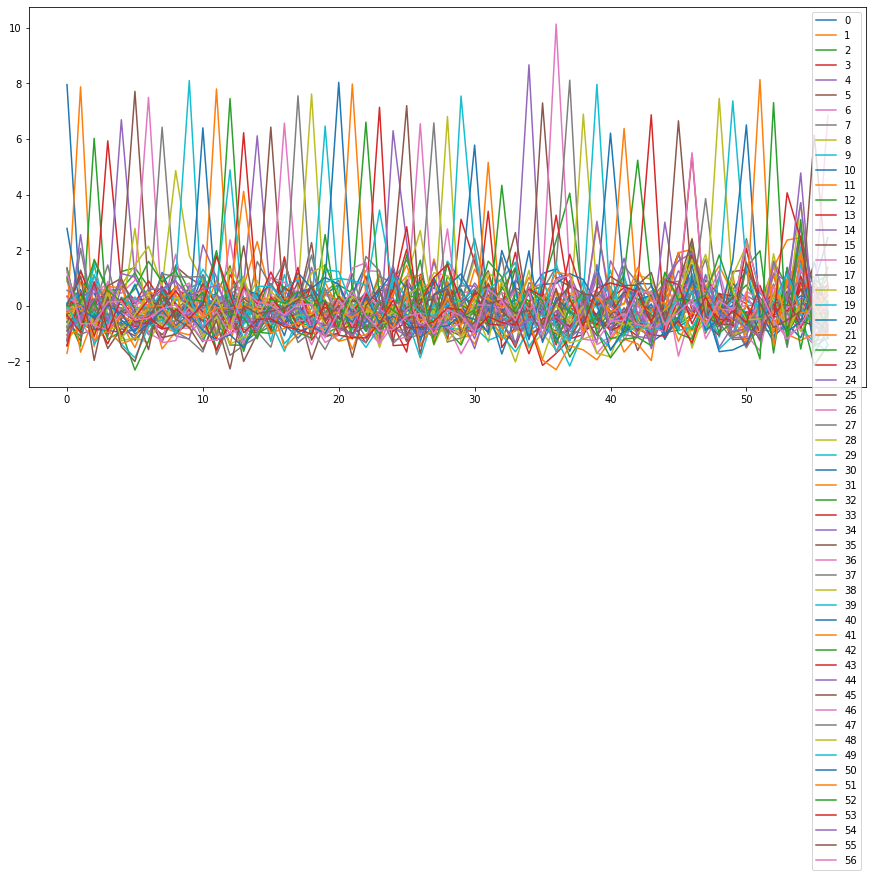

In [25]:
glue_task = "Sara"

logits_avg = {kind: {cls: np.zeros_like(classes[glue_task], dtype=np.float) for cls in classes[glue_task]} 
              for kind in ["true", "pred"]}

for i, sample in data.iterrows():
    logits = np.array([float(l) for l in sample["logits"].split(",")])
    logits_avg["true"][sample["label"]] += logits
    logits_avg["pred"][sample["pred"]] += logits
for cls in classes[glue_task]:
    n_pred = (data["pred"] == cls).sum()
    n_true = (data["label"] == cls).sum()
    if n_pred != 0:
        logits_avg["pred"][cls] /= n_pred
    logits_avg["true"][cls] /= n_true
plt.figure(figsize=(15, 7))
for cls in classes[glue_task]:
    plt.plot(logits_avg["true"][cls], label=cls)
plt.legend()
plt.show()

## Computing average entropy

In [8]:
entropies = []
for i, sample in data.iterrows():
    logits = np.array([float(l) for l in sample["logits"].split(",")])
    probs = softmax(logits)
    H = entropy(probs)
    entropies.append(H)
H_mean = np.mean(entropies)
H_std = np.std(entropies)
print(H_mean, H_std)

0.2820318261129553 0.19211760758900245
